## Creating JSON database to store metadata information
*Author:* Corrado Motta - corradomotta92@gmail.com

In this notebook, we use [pysondb](https://github.com/pysonDB/pysonDB-v2) to generate lightweight JSON based database with unique IDs. Such database contains respectively the minimum set of global attributes (either mandatory or optional) and all the robotic variables comprising the required metadata.

### Create JSON database for global metadata

First of all we import all the needed packages.

In [1]:
import sys
sys.path.append("fairdata")

# To read CSV tables
import pandas as pd
# To interact with the database
from fairdata import metadataDB

Then we read the CSV table where the global metadata we decided to be the minimum set are stored. 

In [2]:
table_path = "tables/Minimal global metadata set.csv"
global_metadata = pd.read_csv(table_path, # path to the table
                              usecols = range(2,9), # columns to be included
                              nrows = 35, # number of rows to consider
                              skiprows = [0,1,2]) # how many initial rows to skip
# replace NaN with empty string
global_metadata = global_metadata.fillna('')

Check that the table looks like expected

In [3]:
global_metadata

,Name,Description,ISO19115 Name,M-O-NI,ACDD name,Default value,Auto
0,Title,A brief title for the dataset,/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,M,title,,no
1,Abstract,"A short summary for dataset, the content and p...",/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,M,summary,,no
2,keywords,A comma separated list of key words and phrases,/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,M,keywords,"unmanned marine vehicles,marine robotics,auton...",no
3,Conventions,A comma-separated list of the conventions that...,NOT FOUND,M,Conventions,"ACDD-1.3,CF-1.6",no
4,keywords vocabulary,"Guideline for the words/phrases in your ""keywo...",/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,O,keywords_vocabulary,,no
5,PI name,Name of the PI,/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,M,creator_name,,no
6,PI email,Email to the PI,/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,M,creator_email,,no
7,PI institution,Affiliation of the PI,/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,M,institution,CNR-INM,no
8,Dataset start time,ISO8601 reference for the dataset,/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,M,time_coverage_start,,yes
9,Dataset end time,ISO8601 reference for the dataset,/gmi:MI_Metadata/gmd:identificationInfo/gmd:MD...,M,time_coverage_end,,yes


In [4]:
# used to generate rst table for the documentation

if(False):
    print(global_metadata['ACDD name'].map(lambda x: len(x)).max())
    table_frm = "+------------------------------+---------------------------------------------------------------------------------------------------------+------------------------------+"
    split = [element for element in table_frm.split("+") if len(element)!=0]
    for index, row in global_metadata.iterrows():
        # set True value in case is mandatory otherwise false
        if(row['M-O-NI'].lower() == "o"):
            name_string = "{0}".format(row['Name'].strip())
            white_spaces = len(split[0]) - len(name_string) 
            name_string += ' '*white_spaces
            description_string ="{0}".format(row['Description'].strip())
            white_spaces = len(split[1]) - len(description_string)      
            description_string += ' '*white_spaces
            acdd_string = "{0}".format(row['ACDD name'].strip())
            white_spaces = len(split[2]) - len(acdd_string) 
            acdd_string += ' '*white_spaces

            final_string = "|{0}|{1}|{2}|".format(name_string,description_string,acdd_string)
            print(final_string)
            print(table_frm)

We would like to create a json database, where for each global metadata we get:
* Unique ID
* Informal name
* ACDD name
* Whether it is Mandatory or Optional
* Default value
* Description
* Whether it is automatically generated or not

In [5]:
# Create database by specyfing the unique key as well
global_db = metadataDB.metadataDB('database/global_metadata.json','ACDD')

Creating new database with name global_metadata.json


In [6]:
# iterate over our table
for index, row in global_metadata.iterrows():
    # set True value in case is mandatory otherwise false
    if(row['M-O-NI'].lower() == "m"):
        mandatory = True
    else:
        mandatory = False
        
    if(row['Auto'].lower() == "yes"):
        isAuto = True
    else:
        isAuto = False

    # add a row for each element only if ACDD is present
    if(row['ACDD name'] and row['ACDD name'] !="-"):
        global_db.add({
            'name':     row['Name'].strip(),
            'ACDD':     row['ACDD name'].strip(),
            'required': mandatory,
            'default': row['Default value'].strip(),
            'description' : row['Description'].strip(),
            'auto': isAuto
        })

The JSON database is now created. This can be dinamically used during the generation of file NECTDF or ISO, to check if all mandatory elements are filled as expected.

### Create JSON database for robotic variable attributes

We are currently working on identifying the correct names and attributes for our robotic and scientific variables following, when possible, the existing standards. We decided on a minimum set of attributes for each variable. Such attributes are taken from ACDD and CF conventions. The attributes should be:

1. __long_name__: in case a standard_name is not found on CF convention, the long_name will assume that role. Otherwise standard_name and long_name coincide.
2. __standard_name__: Standard name following CF [table](https://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html).
3. __units__: A character string that specifies the units used for the variable's data (empty if dimensionless).
4. __coverage_content_type__: An ISO 19115-1 code to indicate the source of the data e.g., physicalMeasurement, auxiliaryInformation, or modelResult).
5. __comment__: Miscellaneous information about the data or methods used to produce it. This is especially important for the variables that do not have a standard_name. Can be omitted in the other case.

Considering that in the telemetry of a robotic vehicle the same variable can be measured by two or more different sensors (e.g. GPS position given by 3, 4 different GPS on board), we need to be able to give a __custom__ name to each variable in the log, but also a __pointer__ to the standard variable. In that way, the log can be automatically used to generate a NETCDF4 FAIR-compliant file, where besides the global metadata, each variable contains all needed attributes to be found and understood both by machine and humans.

Therefore, the idea is to create another JSON database that contains all of our robotic and scientific variables, comprising the attributes mentioned above. Each variable in the database is saved with a unique ID.

The log file should then contains __two lines__ for the the header like in the following example:
```
NGC_latitude, NGC_longitude, MBES_latitude, MBES_longitude
latitude, longitude, latitude, longitude
45.438759, 12.327145, 45.515624, 12.419372
45.438760, 12.327148, 45.515635, 12.419332
45.438750, 12.327103, 45.515690, 12.419345
```

As we can see the first header line contains the custom name. The second one contains the ID of the standard variable that it refers to. The two different latitudes refer to the same ID as well as the two longitudes. When the other notebook of this repository is launched, it reads the header of the log files, get the IDs, open the JSON database and find the correspondent attributes for that specific variable. In this case, the database looks something like the following snippet:

```json
"271595412737": {
    "long_name": "latitude",
    "standard_name": "latitude",
    "units": "degree_north",
    "coverage_content_type": "physicalMeasurement",
    "comment": "Latitude measured by GPS"
},
"32523223453": {
    "long_name": "longitude",
    "standard_name": "longitude",
    "units": "degree_east",
    "coverage_content_type": "physicalMeasurement",
    "comment": "Longitude measured by GPS"
}
```

By retrieving the attributes using the ID, it can then fill the NETCDF and makes it FAIR-compliant. When the NetCDF is open, the variable will be visualized as follow:

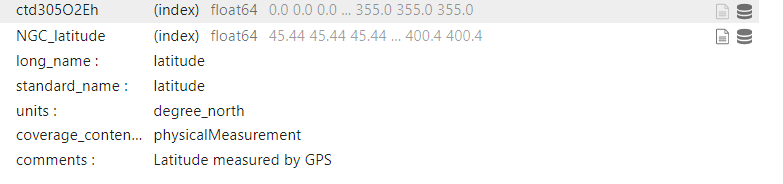

The complete table is not ready yet, therefore we import one that is solely used as mock for the code.

In [7]:
table_path = "tables/variable_metadata.csv"
variable_metadata = pd.read_csv(table_path, # path to the table
                              usecols = range(2,8), # columns to be included
                              nrows = 29, # number of rows to consider
                              skiprows = range(0,24)) # how many initial rows to skip
# replace NaN with empty string
variable_metadata = variable_metadata.fillna('')

In [8]:
variable_metadata

,Log Name,Comment,Long Name,Standard Name,Unit,coverage_content_type
0,date,Date in format yyyymmdd,date,,,physicalMeasurement
1,time,Time in format hhmmss.ms,time,time,s,physicalMeasurement
2,latitude,Latitude is positive northward; its units of d...,latitude,latitude,degree_north,physicalMeasurement
3,longitude,Longitude is positive eastward; its units of d...,longitude,longitude,degree_east,physicalMeasurement
4,xgps,x indicates a vector component along the grid ...,projection_x_coordinate,projection_x_coordinate,m,auxiliaryInformation
5,ygps,y indicates a vector component along the grid ...,projection_y_coordinate,projection_y_coordinate,m,auxiliaryInformation
6,horizontalAccuracy,Horizontal accuracy represents the radius of t...,horizontalAccuracy,,m,physicalMeasurement
7,llhPositionValidFlags,Flag that indicates if the measurements is val...,llhPositionValidFlags,,,auxiliaryInformation
8,roll,Roll rotation. The angle that identifies the r...,platform_roll,platform_roll,degree,physicalMeasurement
9,pitch,Pitch rotation. The angle that identifies the ...,platform_pitch,platform_pitch,degree,physicalMeasurement


In [9]:
# Create database
variable_db = metadataDB.metadataDB('database/variable_metadata.json')

# version. TODO should be automatically set
version = "1.0"

# iterate over our table
for index, row in variable_metadata.iterrows():
    # add a row for each element
        variable_db.add({
            'long_name':             row['Long Name'].strip(),
            'standard_name':         row['Standard Name'].strip(),
            'units':                 row['Unit'].strip(),
            'coverage_content_type': row['coverage_content_type'].strip(),
            'comment':               row['Comment'].strip(),
            'version':               version
        })

Database with name variable_metadata.json already existing.                 All further operation will directly connect to it.


In [10]:
variable_db.getAll()

{'336590390693271180': {'long_name': 'date',
  'standard_name': '',
  'units': '',
  'coverage_content_type': 'physicalMeasurement',
  'comment': 'Date in format yyyymmdd',
  'version': '1.0'},
 '245479688150730311': {'long_name': 'time',
  'standard_name': 'time',
  'units': 's',
  'coverage_content_type': 'physicalMeasurement',
  'comment': 'Time in format hhmmss.ms',
  'version': '1.0'},
 '852129050816343194': {'long_name': 'latitude',
  'standard_name': 'latitude',
  'units': 'degree_north',
  'coverage_content_type': 'physicalMeasurement',
  'comment': 'Latitude is positive northward; its units of degree_north (or equivalent) indicate this explicitly.',
  'version': '1.0'},
 '322512985147273601': {'long_name': 'longitude',
  'standard_name': 'longitude',
  'units': 'degree_east',
  'coverage_content_type': 'physicalMeasurement',
  'comment': 'Longitude is positive eastward; its units of degree_east (or equivalent) indicate this explicitly.',
  'version': '1.0'},
 '5688812544792523

In [11]:
#variable_id = "271595412737339974"
#print("standard name:", db.get_by_id(variable_id)['long_name'])
#print("description:", db.get_by_id(variable_id)['comments'])
#print("type:", db.get_by_id(variable_id)['coverage_content_type'])